In [1]:
import numpy as np
import cv2
import argparse
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json
import disparity_one_frame

In [2]:
json_file = "../oak_2024-04-08-10-52-07_0_converted_2024-04-09-14-35-58-camchain.json"
with open(json_file) as f:
    data = json.load(f)

print(data)
print(data["cam1"]["T_cn_cnm1"])

{'cam0': {'cam_overlaps': [1], 'camera_model': 'pinhole', 'distortion_coeffs': [0.3595682049211609, 0.2799452613167447, -0.005572845182351773, 0.005589078008178134], 'distortion_model': 'radtan', 'intrinsics': [596.7375826739508, 597.0778377216482, 329.3072579090607, 237.31223320757667], 'resolution': [640, 480], 'rostopic': '/oak_d_lite/left/image_mono/compressed'}, 'cam1': {'T_cn_cnm1': [[0.9999696225471487, 0.004164140687029577, -0.006588923678911082, -0.07450866484484225], [-0.004169831872755054, 0.9999909447485973, -0.0008502487611280894, -0.00027775177542922063], [0.006585323459090403, 0.0008776976366999126, 0.9999779313373834, -0.0008551555681102787], [0.0, 0.0, 0.0, 1.0]], 'cam_overlaps': [0], 'camera_model': 'pinhole', 'distortion_coeffs': [0.35533974338967517, 0.33185241198948917, -0.00031781526627002723, 0.0012753847775669], 'distortion_model': 'radtan', 'intrinsics': [592.3760711649045, 592.8996741853884, 311.10959871616603, 244.7667424793336], 'resolution': [640, 480], 'ro

In [3]:
baseline = 75*1e-3
left_image_path = "../Extracted-Frames/Stereo-Camera-Left/Stereo-Camera-Left-Frame2.jpg"
right_image_path = "../Extracted-Frames/Stereo-Camera-Right/Stereo-Camera-Right-Frame2.jpg"

left_intrinsic = np.array(data["cam0"]["intrinsics"])
left_distortion = np.array(data["cam0"]["distortion_coeffs"])
right_intrinsic = np.array(data["cam1"]["intrinsics"])
right_distortion = np.array(data["cam1"]["distortion_coeffs"])

cam0_matrix = np.array([[left_intrinsic[0], 0, left_intrinsic[2]],[0, left_intrinsic[1], left_intrinsic[3]],[0, 0, 1]])
cam1_matrix = np.array([[right_intrinsic[0], 0, right_intrinsic[2]],[0, right_intrinsic[1], right_intrinsic[3]],[0, 0, 1]])

rotation = np.array([l[0:3] for l in data["cam1"]["T_cn_cnm1"]][0:3])
translation = np.array([l[3] for l in data["cam1"]["T_cn_cnm1"]][0:3])

print(rotation)
print(translation)

min_disparity = 0
num_disparities = 16
block_size = 5

[[ 9.99969623e-01  4.16414069e-03 -6.58892368e-03]
 [-4.16983187e-03  9.99990945e-01 -8.50248761e-04]
 [ 6.58532346e-03  8.77697637e-04  9.99977931e-01]]
[-0.07450866 -0.00027775 -0.00085516]


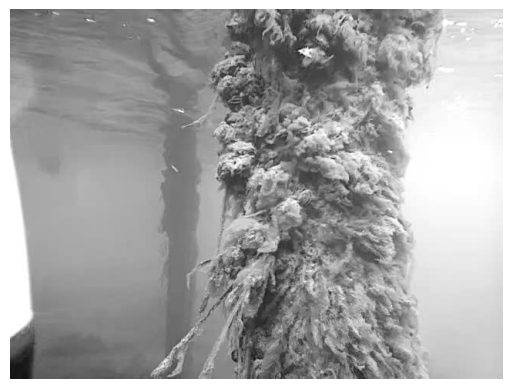

In [4]:
img_left = mpimg.imread(left_image_path)
img_right = mpimg.imread(right_image_path)
plt.imshow(img_left)
plt.axis('off')  # Turn off axis
plt.show()

In [5]:
img_size_left = img_left.shape
(left_rectification, right_rectification, left_projection, right_projection, disparityToDepthMap, left_ROI, right_ROI) = cv2.stereoRectify(cam0_matrix, left_distortion, cam1_matrix, right_distortion, (img_size_left[1],img_size_left[0]), rotation, translation, None, None, None, None, None, cv2.CALIB_ZERO_DISPARITY, 0)

leftMapX, leftMapY = cv2.initUndistortRectifyMap(cam0_matrix, left_distortion, left_rectification, left_projection, (img_size_left[1],img_size_left[0]), cv2.CV_32FC1)
rightMapX, rightMapY = cv2.initUndistortRectifyMap(cam1_matrix, right_distortion, right_rectification, right_projection, (img_size_left[1],img_size_left[0]), cv2.CV_32FC1)

In [8]:
stereoMatcher = cv2.StereoBM.create(numDisparities=num_disparities, blockSize=block_size)

fixedLeft = cv2.remap(img_left, leftMapX, leftMapY, cv2.INTER_NEAREST)
fixedRight = cv2.remap(img_right, rightMapX, rightMapY, cv2.INTER_NEAREST)

grayLeft = cv2.cvtColor(fixedLeft, cv2.COLOR_BGR2GRAY)
grayRight = cv2.cvtColor(fixedRight, cv2.COLOR_BGR2GRAY)

disparity = stereoMatcher.compute(grayLeft, grayRight)
print(disparity)

DEPTH_VISUALIZATION_SCALE = 1
cv2.imshow('disparity', disparity / DEPTH_VISUALIZATION_SCALE)
plt.show()

[[ 95  95  95 ... 246 246 245]
 [ 96  96  96 ... 245 245 245]
 [ 95  95  95 ... 244 244 245]
 ...
 [ 90  90  91 ... 212 212 212]
 [ 89  90  91 ... 212 212 212]
 [ 89  90  90 ... 212 212 212]]
[[-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 ...
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]]


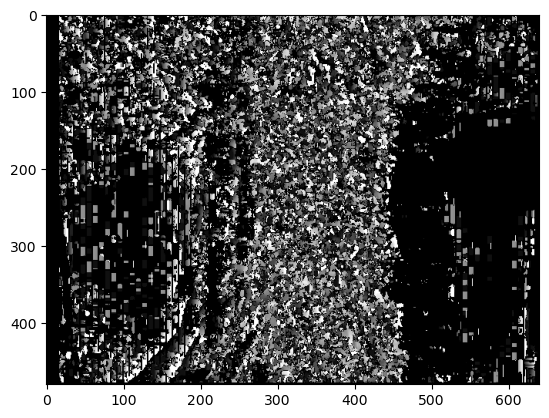

/home/rlarnouh/fuaos-pile-inspection/disparity_depth_maps/disparity_one_frame.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  depth_map[i, j] = (baseline * left_intrinsic[0]) / disparity[i, j]


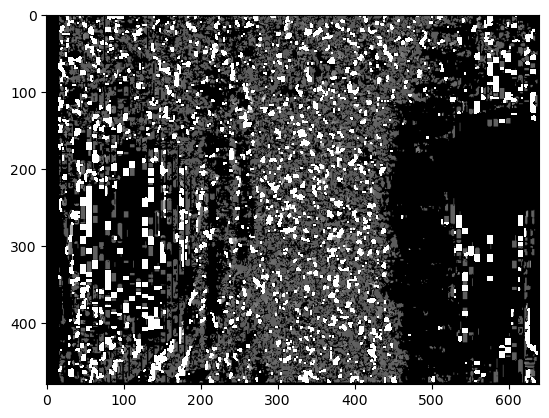

In [7]:
disparity_one_frame.main(baseline,left_image_path,right_image_path,left_intrinsic,left_distortion,right_intrinsic,right_distortion,min_disparity,num_disparities,block_size)